# Imports

In [49]:
import pandas as pd
import os, time,json
import tmdbsimple as tmdb 
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt

# Getting API Credentials

In [2]:
with open('C:/Users/grace/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
## Display the keys of the loaded dict
login.keys()

dict_keys(['api-key', 'api-token'])

In [3]:
tmdb.API_KEY =  login['api-key']

# Check Data Folder

In [4]:
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['.ipynb_checkpoints',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'title_akas.csv.gz',
 'title_basics.csv.gz',
 'title_ratings.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json']

# Defined Functions

In [5]:
def get_movie_with_rating(movie_id):
    # Get the movie object for the current id
    movie = tmdb.Movies(movie_id)
    
    # save the .info .releases dictionaries
    info = movie.info()
    releases = movie.releases()
    
    # Loop through countries in releases
    for c in releases['countries']:
    # if the country abbreviation==US
        if c['iso_3166_1' ] =='US':
        ## save a "certification" key in the info dict with the certification
           info['certification'] = c['certification']
    return info

In [6]:
def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

# Loading in Basics Data

In [7]:
# Load in the dataframe from project part 1 as basics:
basics = pd.read_csv("Data/title_basics.csv.gz")
basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El Tango del Viudo y Su Espejo Deformante,0,2020.0,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
4,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002.0,NaN,126,Drama
...,...,...,...,...,...,...,...,...,...
83999,tt9914942,movie,Life Without Sara Amat,La vida sense la Sara Amat,0,2019.0,NaN,74,Drama
84000,tt9915872,movie,The Last White Witch,My Girlfriend is a Wizard,0,2019.0,NaN,97,"Comedy,Drama,Fantasy"
84001,tt9916170,movie,The Rehearsal,O Ensaio,0,2019.0,NaN,51,Drama
84002,tt9916190,movie,Safeguard,Safeguard,0,2020.0,NaN,95,"Action,Adventure,Thriller"


# Retreiving Needed Details with ID

In [8]:
YEARS_TO_GET = [2000,2001]

In [9]:
errors = [ ]

In [10]:
for i in YEARS_TO_GET:
    for j in range(5):
        print(i,j)
    print("YEARS = ",i)

2000 0
2000 1
2000 2
2000 3
2000 4
YEARS =  2000
2001 0
2001 1
2001 2
2001 3
2001 4
YEARS =  2001


In [11]:
# Start of OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
        #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    # Check if file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
    # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
    #Saving new year as the current df
    df = basics.loc[ basics['startYear']==YEAR].copy()
    # saving movie ids to list
    movie_ids = df['tconst'].copy()
    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)
    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
        #Get index and movie id from list
    # INNER Loop
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
            # Retrieve then data for the movie id
            temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
            
        except Exception as e:
            errors.append([movie_id, e])
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

Movies from 2000:   0%|          | 0/206 [00:00<?, ?it/s]

Movies from 2001:   0%|          | 0/240 [00:00<?, ?it/s]

In [12]:
print(f"- Total errors: {len(errors)}")

- Total errors: 446


# Exploratory Data Analysis

## Concatenated Dataframe

In [22]:
# Open saved file and preview again
final2000 = pd.read_csv("Data/final_tmdb_data_2000.csv.gz", low_memory = False)
final2000.info()
final2000.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                1216 non-null   object 
 1   adult                  1215 non-null   float64
 2   backdrop_path          651 non-null    object 
 3   belongs_to_collection  111 non-null    object 
 4   budget                 1215 non-null   float64
 5   genres                 1215 non-null   object 
 6   homepage               66 non-null     object 
 7   id                     1215 non-null   float64
 8   original_language      1215 non-null   object 
 9   original_title         1215 non-null   object 
 10  overview               1192 non-null   object 
 11  popularity             1215 non-null   float64
 12  poster_path            1085 non-null   object 
 13  production_companies   1215 non-null   object 
 14  production_countries   1215 non-null   object 
 15  rele

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.109,2058.0,PG


In [23]:
final2001 = pd.read_csv("Data/final_tmdb_data_2001.csv.gz", low_memory = False)
final2001.info()
final2001.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293 entries, 0 to 1292
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                1293 non-null   object 
 1   adult                  1292 non-null   float64
 2   backdrop_path          673 non-null    object 
 3   belongs_to_collection  87 non-null     object 
 4   budget                 1292 non-null   float64
 5   genres                 1292 non-null   object 
 6   homepage               107 non-null    object 
 7   id                     1292 non-null   float64
 8   original_language      1292 non-null   object 
 9   original_title         1292 non-null   object 
 10  overview               1263 non-null   object 
 11  popularity             1292 non-null   float64
 12  poster_path            1147 non-null   object 
 13  production_companies   1292 non-null   object 
 14  production_countries   1292 non-null   object 
 15  rele

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0035423,0.0,/hfeiSfWYujh6MKhtGTXyK3DD4nN.jpg,NaN,48000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232.0,en,Kate & Leopold,...,76019048.0,118.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.0,6.321,1162.0,PG-13
2,tt0114447,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,151007.0,en,The Silent Force,...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They left him for dead... They should have fin...,The Silent Force,0.0,5.000,3.0,NaN
3,tt0118589,0.0,/9NZAirJahVilTiDNCHLFcdkwkiy.jpg,NaN,22000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,10696.0,en,Glitter,...,5271666.0,104.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"In music she found her dream, her love, herself.",Glitter,0.0,4.600,118.0,PG-13
4,tt0118652,0.0,/mWxJEFRMvkG4UItYJkRDMgWQ08Y.jpg,NaN,1000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",NaN,17140.0,en,The Attic Expeditions,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,His search for peace of mind... will leave his...,The Attic Expeditions,0.0,5.100,28.0,R


In [38]:
final_df = pd.concat([final2000, final2001])
final_df.info()
final_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2509 entries, 0 to 1292
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                2509 non-null   object 
 1   adult                  2507 non-null   float64
 2   backdrop_path          1324 non-null   object 
 3   belongs_to_collection  198 non-null    object 
 4   budget                 2507 non-null   float64
 5   genres                 2507 non-null   object 
 6   homepage               173 non-null    object 
 7   id                     2507 non-null   float64
 8   original_language      2507 non-null   object 
 9   original_title         2507 non-null   object 
 10  overview               2455 non-null   object 
 11  popularity             2507 non-null   float64
 12  poster_path            2232 non-null   object 
 13  production_companies   2507 non-null   object 
 14  production_countries   2507 non-null   object 
 15  rele

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.109,2058.0,PG


## Movies with Valid Financial Info

In [39]:
budget = (final_df['budget'] > 0)
rev = (final_df['revenue'] > 0)

In [40]:
filter = (budget | rev)

In [54]:
filter.value_counts()

False    1882
True      627
dtype: int64

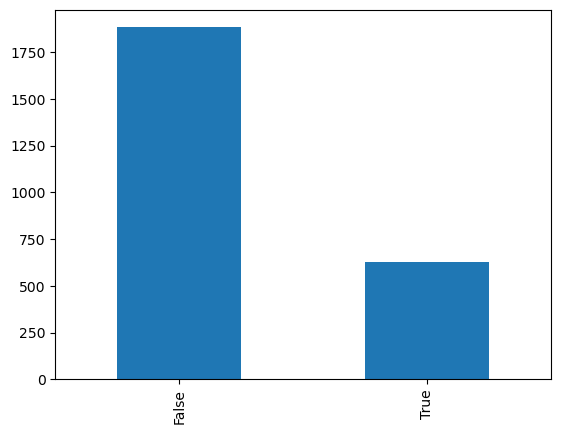

In [61]:
filter.value_counts().plot(kind='bar');

## How Many Movies in Each Certification

In [43]:
final_df['certification'].value_counts()

R          454
PG-13      182
NR          67
PG          63
G           24
NC-17        6
Unrated      1
-            1
Name: certification, dtype: int64

## Average Revenue Per Cert Category

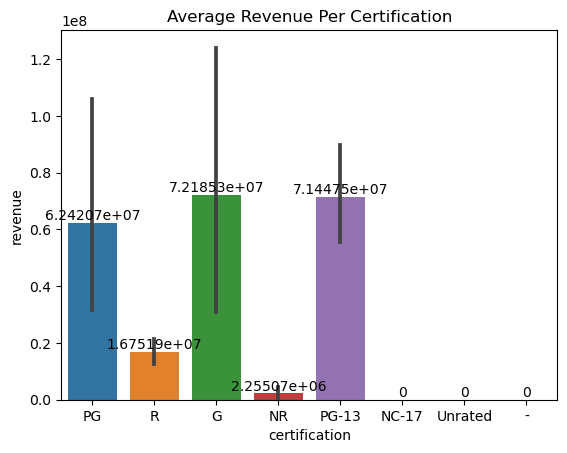

In [66]:
ax = sns.barplot(data = final_df, x = 'certification', y = 'revenue')
ax.bar_label(ax.containers[0])
plt.title("Average Revenue Per Certification");

## Average Budget Per Cert Category

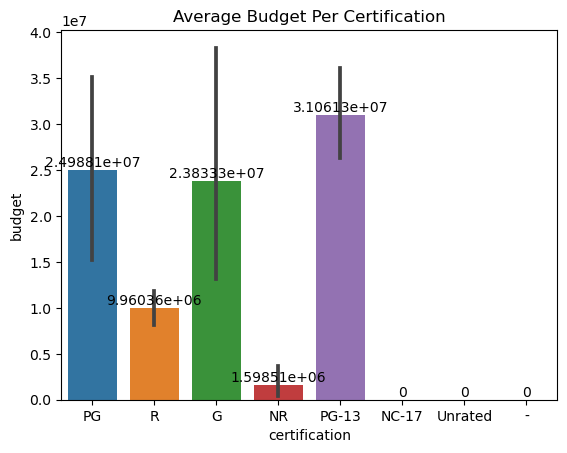

In [64]:
ax = sns.barplot(data = final_df, x = 'certification', y = 'budget')
ax.bar_label(ax.containers[0])
plt.title("Average Budget Per Certification");